# Mass balance type intercomparison with one flowline for Hintereisferner 

In [1]:
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  

from functools import partial
import shutil
import copy
import time
import numpy as np
import pandas as pd
from numpy.testing import assert_allclose
import scipy
from scipy.stats import linregress
import os
import pytest
import matplotlib.pyplot as plt
import xarray as xr
import oggm

# imports from OGGM
from oggm.core import massbalance
from oggm import utils, workflow, tasks, cfg
from oggm.cfg import SEC_IN_DAY, SEC_IN_YEAR, SEC_IN_MONTH
from oggm.exceptions import InvalidWorkflowError, InvalidParamsError

# imports from MBsandbox package modules
from MBsandbox.mbmod_daily_oneflowline import process_era5_daily_data, TIModel, BASENAMES
from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq

In [2]:
# get larger figures
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('figure',figsize=(20,10))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
cfg.initialize()

working_dir = '/home/lilianschuster/Schreibtisch/PhD/oggm_files/oneFlowline'
# this needs to be changed if working on another computer
if not os.path.exists(working_dir):
    working_dir = utils.gettempdir(dirname='OGGM_mb_type_intercomparison', reset=True)
    
cfg.PATHS['working_dir'] = working_dir
# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

2021-01-29 18:30:01: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-01-29 18:30:01: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-01-29 18:30:01: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-01-29 18:30:01: oggm.utils: Checking the download verification file checksum...


In [4]:
# get HEF glacier
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10,
                                  prepro_base_url=base_url,
                                  prepro_rgi_version='62')
gd = gdirs[0]
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
# oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5_daily')
process_era5_daily_data(gd)
#         execute_entity_task(tasks.process_climate_data, gdirs,
#                            print_log=False)
# execute_entity_task(tasks.historical_climate_qc, gdirs)
# in test_climate_qc!!!
# automatically in tasks ... (L3)
oggm.core.climate.historical_climate_qc(gd)


h, w = gd.get_inversion_flowline_hw()
fls = gd.read_pickle('inversion_flowlines')

mbdf = gd.get_ref_mb_data()
pf = 2.5

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-01-29 18:30:02: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-01-29 18:30:02: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-01-29 18:30:02: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.00.tar
2021-01-29 18:30:02: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `ERA5_daily`.
2021-01-29 18:30:02: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
2021-01-29 18:30:04: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.

In [5]:
gd.get_diagnostics()

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'dem_source': 'NASADEM', 'flowline_type': 'elevation_band'}

In [6]:
# check if area of  HUSS flowlines corresponds to the rgi area
np.allclose(gd.rgi_area_m2, np.sum(w * gd.grid.dx * fls[0].dx))

True

# Optimization of the bias:

In [7]:
co = ['green','lightgreen','blue','lightblue','red', 'orange']
loop = False
def plot_mb(gd, mb_type = 'mb_monthly', grad_type = 'cte', N = 100, pf = 2.5 , co ='r'):
    """ plots modelled mb time series with performance statistics as labels """
    DDF_opt = scipy.optimize.brentq(minimize_bias,1,10000, args=(mb_type, grad_type, gd, N,
                                                                 pf, loop, False), disp=True, xtol=0.1) 
    gd_mb = TIModel(gd, DDF_opt, mb_type=mb_type, grad_type=grad_type, N=N)
    # check climate and adapt if necessary
    gd_mb.historical_climate_qc_mod(gd)
    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
    RMSD, bias , rcor, quot_std = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
    plt.plot(mbdf.index, mb_specific, color = co,
             label = 'modeled {} {} gradient: RMSD {}, rcor {}, std_quot {}, bias {}'.format(mb_type, grad_type,
                                                                                             RMSD.round(1), rcor.round(3), quot_std.round(3), bias.round(2), ))


2021-01-29 18:30:18: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-01-29 18:30:18: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:30:22: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_temp_monthly.nc verified successfully.
2021-01-29 18:30:27: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_geopotential_monthly.nc verified successfully.
2021-01-29 18:30:39: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_tempstd_monthly.nc verified successfully.
2021-01-29 18:30:40: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-01-29 18:30:40: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: Dep

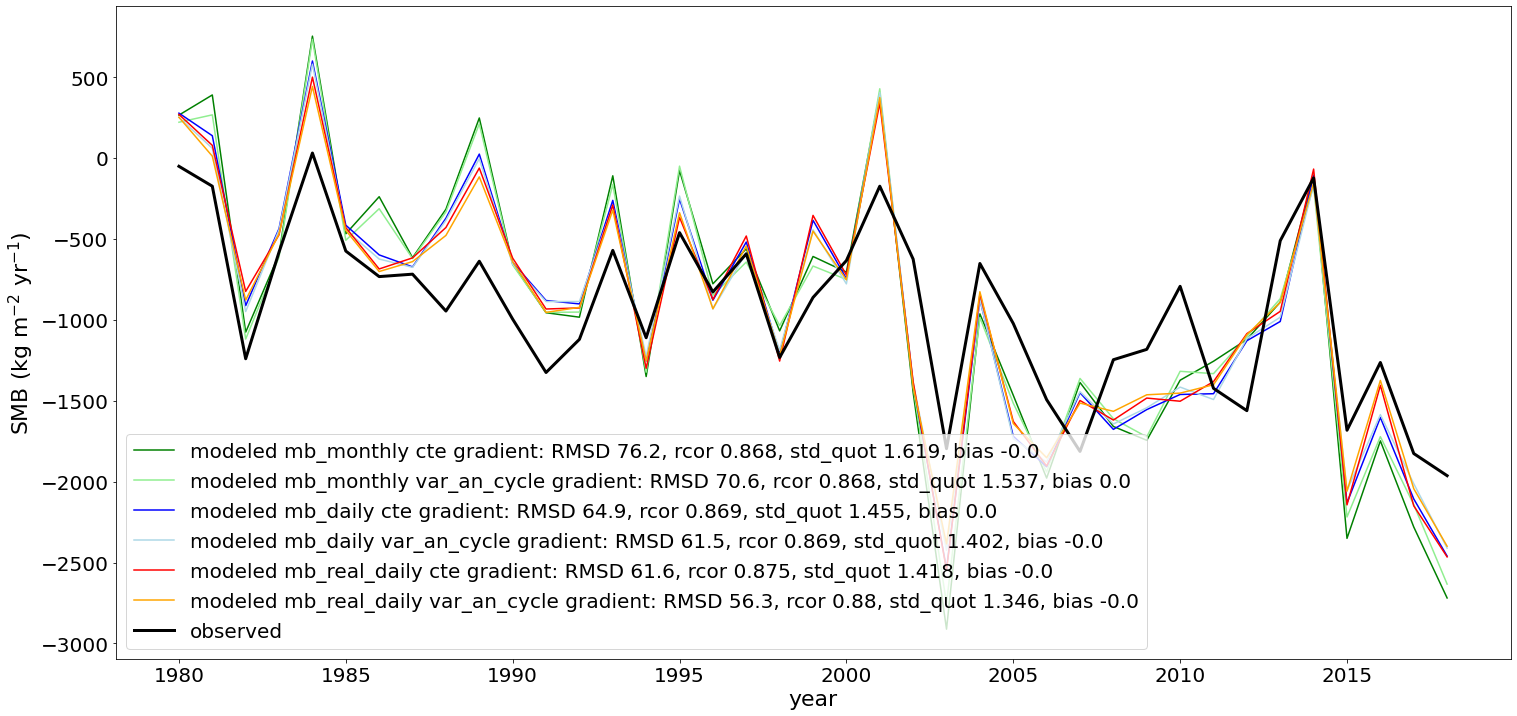

In [8]:
plt.figure(figsize=(25,12))
# for mb_monthly and mb_daily: use ERA5dr climate!
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset='ERA5dr')
j = 0
for mb_type in [ 'mb_monthly','mb_daily']:
    
    for grad in ['cte','var_an_cycle']:
        plot_mb(gd, mb_type = mb_type, grad_type = grad, pf = 2.5, co =co[j]  )
        j += 1

# fpr mb_real_daily: use ERA5_daily climate!
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
process_era5_daily_data(gd)

for mb_type in ['mb_real_daily']:
    for grad in ['cte','var_an_cycle']:
        plot_mb(gd, mb_type = mb_type, grad_type = grad, pf = 2.5, co =co[j] )
        j +=1


plt.plot(mbdf.index,
         mbdf.ANNUAL_BALANCE,
         label = 'observed', color = 'black', lw=3)
plt.legend()
plt.xlabel('year')
plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)');
plt.savefig('./figures_hef/HEF_mb_time_series_mod_obs_6types.pdf')


### check optimization time needed for different amount of percentiles that are used in 'mb_daily' to derive the daily temperature out of the standard deviation


In [9]:
pf = 2.5
mb_type = 'mb_daily'
grad = 'var_an_cycle'

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def plot_optimization_bias_time(optim_type = 'brentq', loop= False, ):
    """ plots amount the bias versus necessary time for different value of N 
    (N is the amount of values taken out of normal distribution to describe daily temperature from mean and daily std)"""
    c = ['k','grey','blue','lightblue','green','orange','red']
    
    # only instantiate it once
    gd_mb = TIModel(gd, 200, mb_type=mb_type, grad_type=grad, prcp_fac=pf, loop=loop, N=100)
    # check climate and adapt if necessary, in this case it is sufficient to do this once!
    gd_mb.historical_climate_qc_mod(gd)
    for j,N in enumerate([1000,  500, 200, 100, 50, 30][::-1]):
        ex_t = time.time()
        # then change N and melt_f accordingly! to save time
        gd_mb.N = N
        if optim_type =='brentq':
            gd_mb.melt_f = DDF_opt = scipy.optimize.brentq(minimize_bias,1,10000, args=(mb_type, grad,gd,N,pf, loop, False), disp=True, xtol=0.1) 
        elif optim_type =='powell':
            gd_mb.melt_f = DDF_opt = scipy.optimize.minimize(minimize_bias, [100], (mb_type, grad,gd,N,pf, loop, True), method = 'Powell').x 

        mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,
                                             year = mbdf.index.values)
        stats = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
        ex_time = time.time() - ex_t
        if loop: 
            plt.plot(ex_time, stats[1],'o',color = c[j],
                     label = '{} loop'.format(N))
        else: 
            plt.plot(ex_time, stats[1],'x',color = c[j],
                 label = '{} noloop'.format(N))

2021-01-29 18:31:00: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-01-29 18:31:00: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


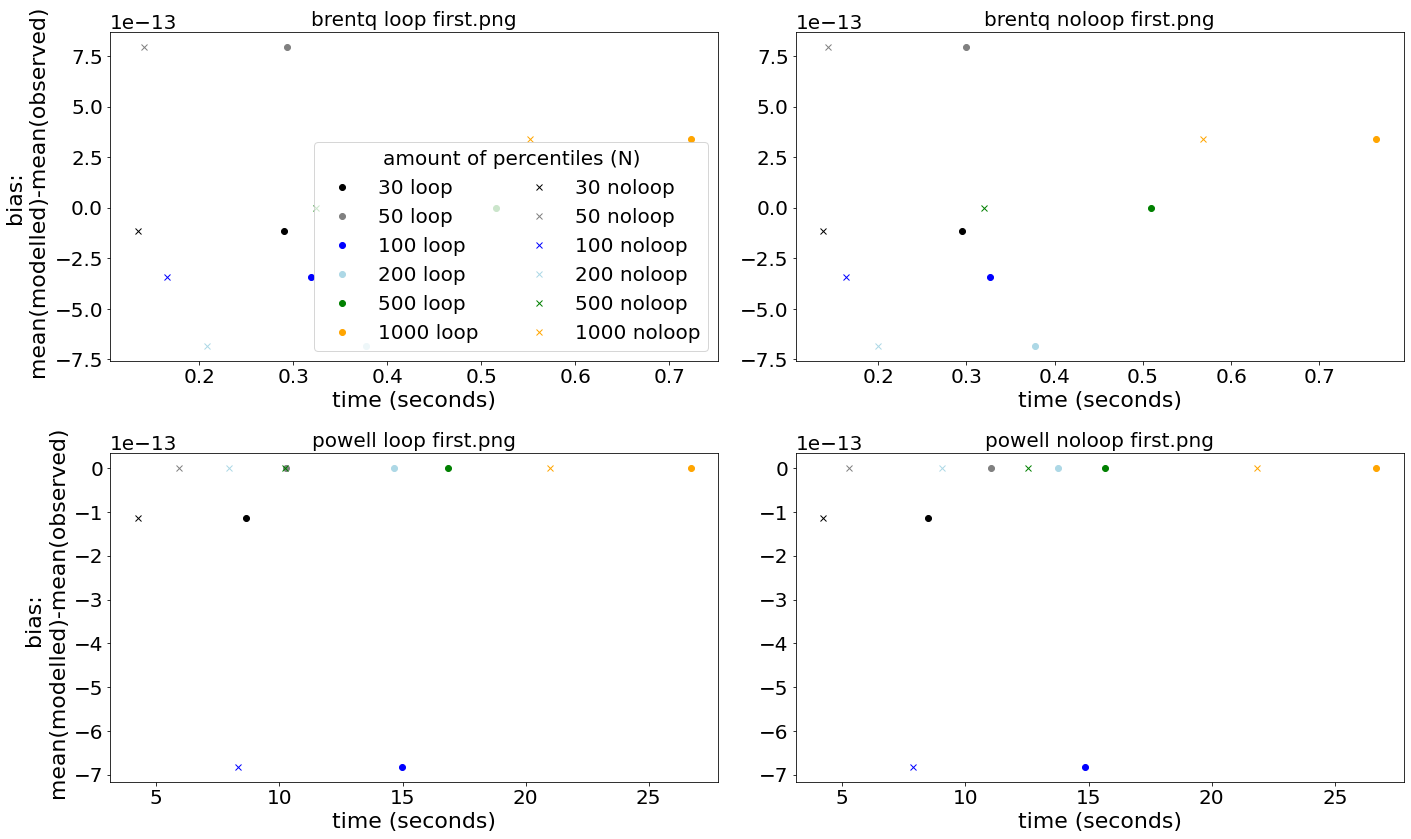

In [11]:
# %%
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
plt.figure(figsize=(20,12))
plt.subplot(221)
plot_optimization_bias_time(optim_type = 'brentq', loop= True )
plot_optimization_bias_time(optim_type = 'brentq', loop= False )
plt.legend(title='amount of percentiles (N)', ncol = 2)
plt.ylabel('bias: \n mean(modelled)-mean(observed)')
plt.xlabel('time (seconds)')
plt.title('brentq loop first.png')
plt.subplot(222)
plot_optimization_bias_time(optim_type = 'brentq', loop= False )
plot_optimization_bias_time(optim_type = 'brentq', loop= True )        
plt.xlabel('time (seconds)')
plt.title('brentq noloop first.png')
          
plt.subplot(223)
plot_optimization_bias_time(optim_type = 'powell', loop= True )
plot_optimization_bias_time(optim_type = 'powell', loop= False )
plt.ylabel('bias: \n mean(modelled)-mean(observed)')
plt.xlabel('time (seconds)')
plt.title('powell loop first.png')
plt.subplot(224)
plot_optimization_bias_time(optim_type = 'powell', loop= False )
plot_optimization_bias_time(optim_type = 'powell', loop= True )        
plt.xlabel('time (seconds)')
plt.title('powell noloop first.png')
plt.tight_layout()

plt.savefig('./figures_hef/optimiser_time_comparison_HEF.pdf')


- noloop is most of the times faster 
- Brentq is much faster
- actually it does not matter which N is used for the computation ... 
    - all calibrate well: so can set N=100, just to have a bit more percentiles than days

# Calibrate additionally the precipitation factor for each glacier such that the standard deviation of modelled and reference mass balance are similar

In [12]:
ddf_opt_pf = {}
ddf_opt = {}
ddf_opt_pf = {}
pf_opt = {}

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
N = 100
loop = False


for mb_type in ['mb_monthly', 'mb_daily','mb_real_daily']: 
    if mb_type == 'mb_monthly' or mb_type =='mb_daily':
        cfg.PARAMS['baseline_climate'] = 'ERA5dr'
        oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
    else:
        cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
        process_era5_daily_data(gd) 
    for grad in ['cte','var_an_cycle']:
        ex_t = time.time()
        # first get the optimal ddf with the default precipitation factor (pf)
        ddf_opt[mb_type+'_'+grad] = scipy.optimize.brentq(minimize_bias,1,10000, xtol = 0.01,
                                    args=(mb_type,grad,gd,N,2.5, loop, False) ) 
        
        # calibrate the optimal precipitation factor
        # in 'optimize_std_quot_brentq' for each pf an optimal DDF is found, 
        # then 1- standard deviation quotient between modelled and reference mass balance is computed, which is then minimised
        pf_opt[mb_type+'_'+grad] = scipy.optimize.brentq(optimize_std_quot_brentq, 0.01, 20, # min/max precipitation factor pf
                          args = (mb_type, grad, gd, N, loop), xtol = 0.01)
        
        # the optimal ddf with the optimal precipitation factor is computed again 
        ddf_opt_pf[mb_type+'_'+grad] = scipy.optimize.brentq(minimize_bias,1,10000, xtol = 0.01,
                                                             args=(mb_type, grad,gd,N,pf_opt[mb_type+'_'+grad], loop, False)) 
        ex_time = time.time() - ex_t
        print(ex_time)



2021-01-29 18:40:11: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


0.6594696044921875


2021-01-29 18:40:13: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


0.8206889629364014
1.3519678115844727


2021-01-29 18:40:16: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-01-29 18:40:16: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data


1.2086737155914307


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)


1.7107717990875244
2.637136220932007


In [14]:
# produce a pd Dataframe 
li = []
for mb_type in ['mb_monthly','mb_daily','mb_real_daily']:
    for grad in ['cte','var_an_cycle']:
        li.append(mb_type+'_'+grad)
        li.append(mb_type+'_'+grad+'_pf')        


pd_stats = pd.DataFrame(columns = ['RMSD','bias','rcor','std_quot'], index = li, data = np.NaN)
pd_stats['pf'] = 2.5
pd_stats['DDF'] = np.NaN
for k in ddf_opt.keys():
    pd_stats.loc[k,'DDF'] = ddf_opt[k]
for k in ddf_opt_pf.keys():
    kk = k +'_pf'
    pd_stats.loc[kk,'DDF'] = ddf_opt_pf[k]
for k in pf_opt.keys():
    kk = k +'_pf'
    pd_stats.loc[kk,'pf'] = pf_opt[k]

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2021-01-29 18:40:21: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-01-29 18:40:21: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:40:21: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5dr` to `ERA5_daily`.
2021-01-29 18:40:21: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_era5_daily_data
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  result = self.variable.argmin(dim, axis, keep_attrs, skipna)
/home/lilianschuster/anaconda3/lib/python3.8/site-packages/xarray/core/dataarray.py:4141: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each d

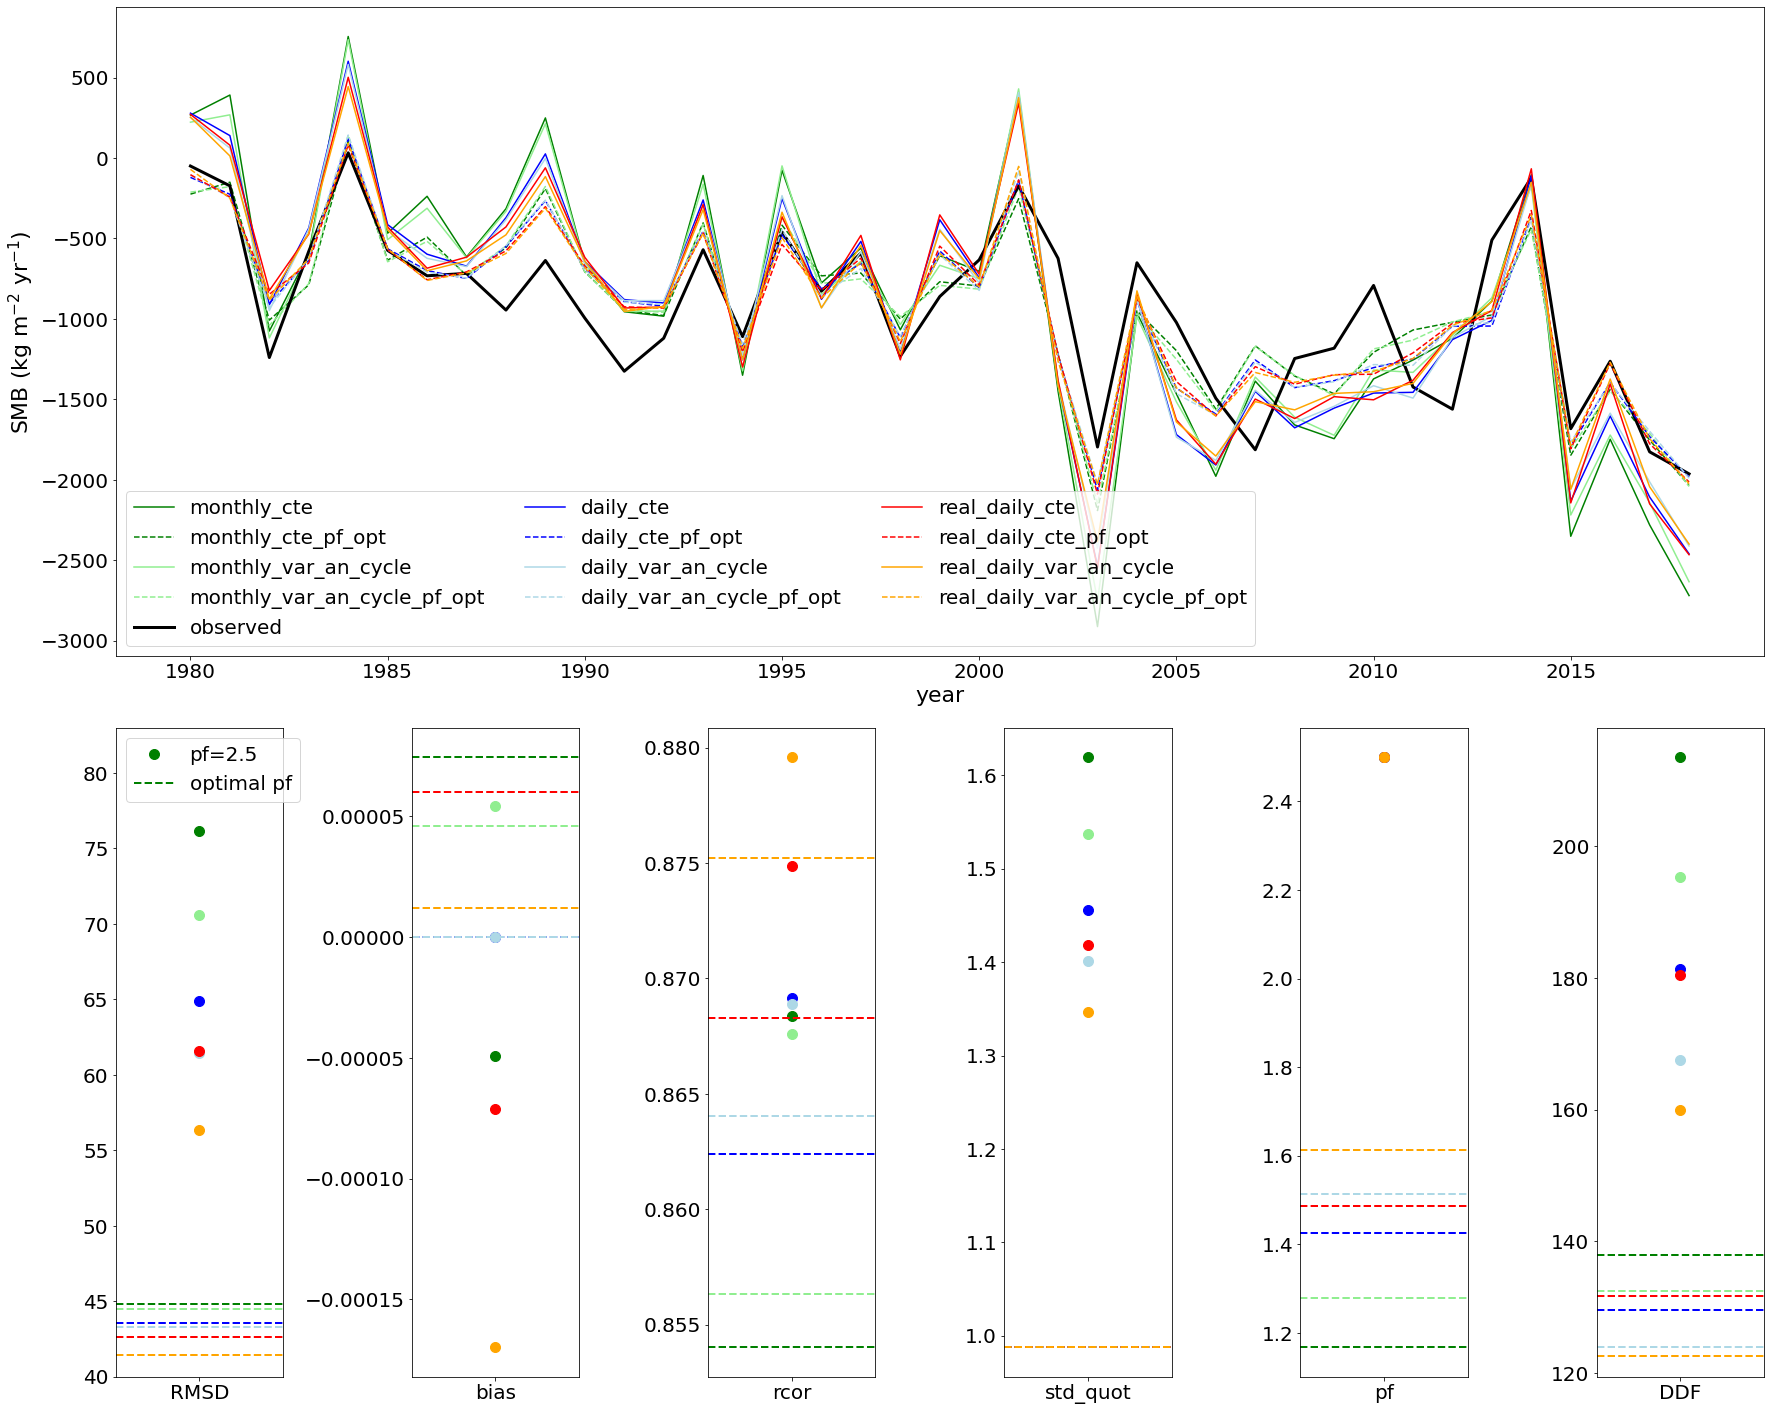

In [15]:
c =['green','lightgreen','blue','lightblue','red', 'orange']
statis = ['RMSD','bias','rcor','std_quot']
mbdf = gd.get_ref_mb_data()

fig = plt.figure(constrained_layout=True, figsize=(25,20))
gs = fig.add_gridspec(2, 6)

ax1 = fig.add_subplot(gs[0, :])
j = 0
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
for mb_type in [ 'mb_monthly','mb_daily']:
    
    for grad in ['cte','var_an_cycle']:

        # default pf = 2.5
        gd_mb = TIModel(gd, ddf_opt[mb_type+'_'+grad],   mb_type=mb_type, N=N,
                           grad_type=grad, prcp_fac = 2.5) 
        mb_mod = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
        pd_stats.loc[mb_type+'_'+grad,statis] = compute_stat(mb_specific=mb_mod, mbdf=mbdf)
        label = mb_type[3:]+'_'+grad
        plt.plot(mbdf.index, mb_mod, label = label, color = c[j])
        
        # optimal pf
        gd_mb_pf = TIModel(gd, ddf_opt_pf[mb_type+'_'+grad],   mb_type=mb_type, N= N,
                              grad_type=grad, prcp_fac = pf_opt[mb_type+'_'+grad]) 
        # check climate and adapt if necessary
        gd_mb_pf.historical_climate_qc_mod(gd)
        mb_mod_pf = gd_mb_pf.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
        pd_stats.loc[mb_type+'_'+grad+'_pf',statis] = compute_stat(mb_specific=mb_mod_pf, mbdf=mbdf)
        label = mb_type[3:]+'_'+grad+'_pf_opt'
        plt.plot(mbdf.index, mb_mod_pf,
                 '--', label =label, color = c[j])
        j +=1
    if mb_type == 'mb_monthly':
        # also plot the observed mass balance 
        plt.plot(mbdf.index,
         mbdf.ANNUAL_BALANCE,
         label = 'observed', color = 'black', lw=3)
        
cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
process_era5_daily_data(gd)

for mb_type in ['mb_real_daily']:
    for grad in ['cte','var_an_cycle']:
        # for pf = 2.5
        gd_mb = TIModel(gd, ddf_opt[mb_type+'_'+grad],   mb_type=mb_type,N=N,
                           grad_type=grad, prcp_fac = 2.5) 
        mb_mod = gd_mb.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
        pd_stats.loc[mb_type+'_'+grad,statis] = compute_stat(mb_specific=mb_mod, mbdf=mbdf)
        label = mb_type[3:]+'_'+grad
        
        # for optimal pf 
        gd_mb_pf = TIModel(gd, ddf_opt_pf[mb_type+'_'+grad],   mb_type=mb_type, N=N,
                              grad_type=grad, prcp_fac = pf_opt[mb_type+'_'+grad])
        # check climate and adapt if necessary
        gd_mb_pf.historical_climate_qc_mod(gd)
        mb_mod_pf = gd_mb_pf.get_specific_mb(heights = h, widths = w, year = mbdf.index.values)
        pd_stats.loc[mb_type+'_'+grad+'_pf',statis] = compute_stat(mb_specific=mb_mod_pf, mbdf=mbdf)
        plt.plot(mbdf.index, mb_mod, label = label, color = c[j])
        label = mb_type[3:]+'_'+grad+'_pf_opt'
        plt.plot(mbdf.index, mb_mod_pf,
                 '--', label =label, color = c[j])
        j +=1


plt.xlabel('year')
plt.ylabel('SMB (kg m$^{-2}$ yr$^{-1}$)')
plt.legend(ncol = 3)

for st,f in zip(['RMSD','bias', 'rcor', 'std_quot', 'pf', 'DDF'],
                [0,1,2,3,4,5]):
    ax_f = fig.add_subplot(gs[1, f])
    for j,r in enumerate(pd_stats[st][::2]):
        plt.plot(st, r,'o', color = c[j], markersize=10,
                 label = 'pf=2.5')# [~np.isna*n(pd_stats['RMSD'].values) 
        plt.axhline(pd_stats[st][j*2+1],ls='--', color = c[j], lw=2,
                    label = 'optimal pf')# [~np.isnan(pd_stats['RMSD'].values) 
        if j ==0 and f ==0:
            plt.legend(loc = 2)
            plt.ylim([40,83])
plt.tight_layout()
plt.savefig('./figures_hef/HEF_mb_stats_mod_obs_12types_pfopt_stats.pdf')


In [18]:
pd_stats
# actually now it runs quite fast, so I don' need to store it anymore
# pd_stats.to_csv('stats_opt_N_{}_{}.csv'.format(N, gd.rgi_id))

,RMSD,bias,rcor,std_quot,pf,DDF
mb_monthly_cte,76.158152,-4.924633e-05,0.868383,1.619379,2.500000,213.561413
mb_monthly_cte_pf,44.852990,7.453917e-05,0.854022,0.987601,1.167568,137.974661
mb_monthly_var_an_cycle,70.575782,5.416301e-05,0.867590,1.537368,2.500000,195.322804
mb_monthly_var_an_cycle_pf,44.498450,4.589444e-05,0.856336,0.987705,1.278970,132.463230
mb_daily_cte,64.867149,5.684342e-13,0.869174,1.455469,2.500000,181.383413
mb_daily_cte_pf,43.546548,2.273737e-13,0.862417,0.987704,1.426330,129.652929
mb_daily_var_an_cycle,61.478986,-3.410605e-13,0.868876,1.401678,2.500000,167.506525
mb_daily_var_an_cycle_pf,43.291077,0.000000e+00,0.864038,0.987787,1.512758,123.920505
mb_real_daily_cte,61.550666,-7.098777e-05,0.874869,1.418001,2.500000,180.419554
mb_real_daily_cte_pf,42.603746,5.999405e-05,0.868298,0.987620,1.486530,131.704821


### Check how fast opt_pf works

- with Brentq it works quite fast, but we will not go deeper into this because we will use geodetic MB measurements anyway!

In [19]:
cfg.PARAMS['baseline_climate'] = 'ERA5dr'
oggm.shop.ecmwf.process_ecmwf_data(gd, dataset = 'ERA5dr')
mb_type = 'mb_daily'
grad = 'cte'

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-01-29 18:40:54: oggm.cfg: PARAMS['baseline_climate'] changed from `ERA5_daily` to `ERA5dr`.
2021-01-29 18:40:54: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data


In [20]:
# If I calibrate first the pf and then calibrate again DDF, however if I get a DDF that 
# gives not the perfect std_quotient
loop = False
for j,N in enumerate([10000, 5000, 2000,1000,500,100, 50][::-1]):
    ex_t = time.time()
    pf_opt = scipy.optimize.brentq(optimize_std_quot_brentq, 0.01, 20, # min/max pf
                          args = (mb_type, grad, gd, N, loop), xtol = 0.01)
    DDF_opt_pf = scipy.optimize.brentq(minimize_bias,1,10000, xtol = 0.01,
                                    args=(mb_type, grad,gd,N,pf_opt, loop, False),
                                    disp=True ) 

    gd_mb = TIModel(gd, DDF_opt_pf, mb_type=mb_type, grad_type=grad,N=N,
                       prcp_fac = pf_opt, loop = loop) #, input_filesuffix=tggrgi_filesuffix, **kwargs)
    # check climate and adapt if necessary
    gd_mb.historical_climate_qc_mod(gd)
    mb_specific = gd_mb.get_specific_mb(heights = h, widths = w,
                                         year = mbdf.index.values)
    stats = compute_stat(mb_specific=mb_specific, mbdf=mbdf)
    ex_time = time.time() - ex_t
    print(ex_time, N, stats, pf_opt, DDF_opt_pf)


/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.1261539459228516 50 [43.552698837281774, -6.821210263296962e-13, 0.8623777644397986, 0.9877036284551769] 1.4240797296105694 129.789998531264
1.0795488357543945 100 [43.54654776384838, 2.2737367544323206e-13, 0.8624166332478725, 0.9877036136481172] 1.4263295122110868 129.65292852577383
2.178133726119995 500 [43.53576808253202, 0.0, 0.8624847586822793, 0.9877037418653336] 1.4283523907599167 129.55149507425807
3.722309112548828 1000 [43.534238058360735, 0.0, 0.8624944346672507, 0.9877038165962185] 1.4286239551964692 129.53979687463442
6.615118503570557 2000 [43.533638986676635, 3.410605131648481e-13, 0.862498232759311, 0.9877039145922726] 1.4287605964471453 129.53410841733907
16.364322662353516 5000 [43.53334993032224, 2.2737367544323206e-13, 0.8625000583789033, 0.9877039120460079] 1.428841793456166 129.53074952526748
34.93287467956543 10000 [43.533268274168336, -5.684341886080801e-13, 0.8625005720573962, 0.9877038967199064] 1.428868164310331 129.5296315073038


# Check why the mass balance profile of the new TIModel does not match the mb profiles

- I do not understand why the mass balance profile does not coincide better with the observed ones 
- is it because of the Huss single flowlines? or because I use another DDF calibration?

/home/lilianschuster/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2021-01-29 18:42:00: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2021-01-29 18:42:00: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-01-29 18:42:01: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:42:01: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:42:01: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:42:01: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:42:01: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data
2021-01-29 18:42:02: oggm.shop.ecmwf: (RGI60-11.00897) process_ecmwf_data

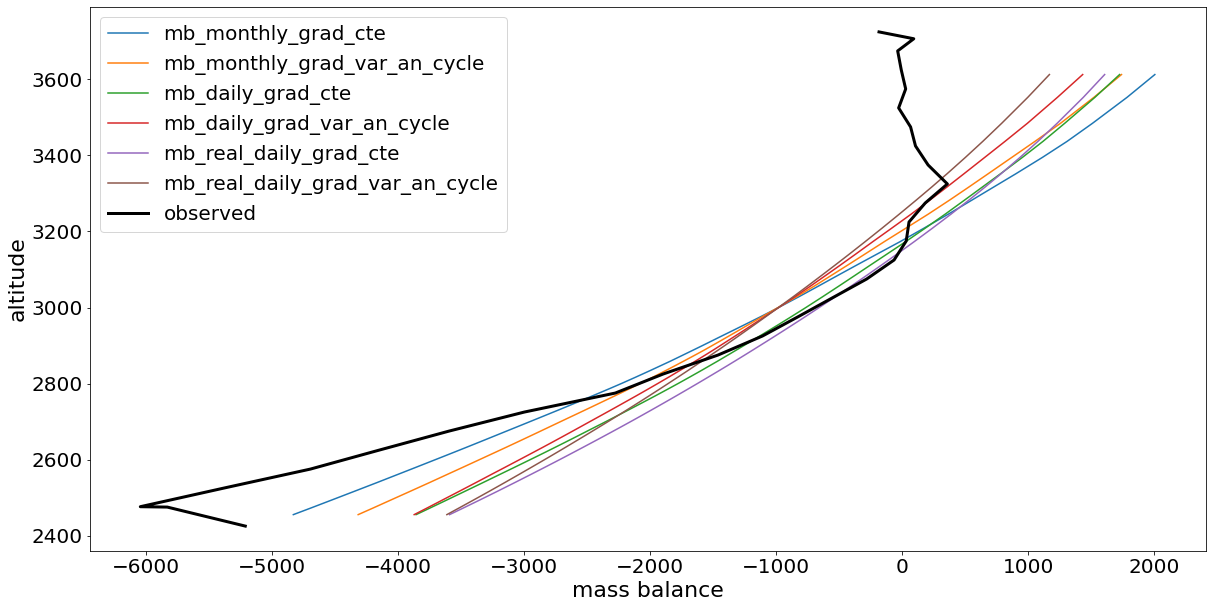

In [21]:
df = ['RGI60-11.00897']
gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                          prepro_border=10, 
                                  prepro_base_url=base_url,
                                  prepro_rgi_version='62')
gdir = gdirs[0]

# init_present_time_glacier(gdir) # if I use this, I have the wrong flowlines

# optimal values of mu_star for cte lapse rates
mu_star_opt = {'mb_monthly': 213.540352,
               'mb_daily':181.054877,
               'mb_real_daily':180.404965}
# optimal values of mu_star when using variable lapse rates:
# 'var_an_cycle'
mu_star_opt_var = {'mb_monthly': 195.304843, 
                            'mb_daily':167.214101, 
                            'mb_real_daily':159.901181}
pf = 2.5

# do this for all model types
for climate in [ 'ERA5dr','ERA5_daily']: # ONLY TEST it for ERA5dr or ERA5_daily!!!
    for mb_type in ['mb_monthly','mb_daily','mb_real_daily']:
        for grad_type in ['cte', 'var_an_cycle']:

            if grad_type =='var_an_cycle':
                fail_err_4 = (mb_type =='mb_monthly') and (climate == 'CRU')
                mu_star_opt = mu_star_opt_var
            else:
                fail_err_4 = False
            if climate =='ERA5dr':
                cfg.PARAMS['baseline_climate'] = 'ERA5dr'
                oggm.shop.ecmwf.process_ecmwf_data(gdir, dataset = "ERA5dr")
            elif climate == 'ERA5_daily':
                cfg.PARAMS['baseline_climate'] = 'ERA5_daily'
                process_era5_daily_data(gdir)
            else:
                tasks.process_climate_data(gdir)
                pass
            # mb_type ='mb_daily'
            fail_err_1 = (mb_type =='mb_daily') and (climate !='ERA5dr')
            fail_err_2 = (mb_type =='mb_monthly') and (climate =='ERA5_daily')
            fail_err_3 = (mb_type =='mb_real_daily') and (climate !='ERA5_daily')


            if fail_err_1 or fail_err_2 or fail_err_3 or fail_err_4:
                with pytest.raises(InvalidParamsError):
                    mb_mod = TIModel(gdir, mu_star_opt[mb_type],
                                        mb_type = mb_type,
                                prcp_fac = pf,
                                t_solid = 0, t_liq =2, t_melt = 0, 
                                default_grad = -0.0065, 
                                grad_type = grad_type)
            else:
                # but this is just a test for reproducibility!
                mb_mod = TIModel(gdir, mu_star_opt[mb_type],
                                    mb_type = mb_type,
                prcp_fac = pf,
                t_solid = 0, t_liq =2, t_melt = 0, 
                default_grad = -0.0065, 
                grad_type = grad_type)
                # check climate and adapt if necessary
                mb_mod.historical_climate_qc_mod(gdir)

                #fls = gdir.read_pickle('inversion_flowlines') # model_flowlines does not work
                #glacier = FlowlineModel(fls)

                mbdf = gdir.get_ref_mb_data()

                #hgts = np.array([])
                #widths = np.array([])
                #for fl in glacier.fls:
                #    hgts = np.concatenate((hgts, fl.surface_h))
                #    widths = np.concatenate((widths, fl.widths_m))
                hgts, widths = gdir.get_inversion_flowline_hw()

                tot_mb = []
                refmb = []
                grads = hgts * 0
                for yr, mb in mbdf.iterrows():
                    refmb.append(mb['ANNUAL_BALANCE'])
                    mbh = (mb_mod.get_annual_mb(hgts, yr) * SEC_IN_YEAR *
                            cfg.PARAMS['ice_density'])
                    grads += mbh
                    tot_mb.append(np.average(mbh, weights=widths))
                grads /= len(tot_mb)

                #tot_mb = mb_mod.get_specific_mb(heights = hgts, 
                #                                widths = widths,


                #assert np.abs(utils.md(tot_mb, refmb)) < 50

                # Gradient THIS GIVES an error!!!
                # possibly because I use the HUSS flowlines ...
                # or is it because I use another calibration?
                dfg = gdir.get_ref_mb_profile().mean()

                # Take the altitudes below 3100 and fit a line
                dfg = dfg[dfg.index < 3100]
                pok = np.where(hgts < 3100)
                slope_obs, _, _, _, _ = linregress(dfg.index,
                                                   dfg.values)
                slope_our, _, _, _, _ = linregress(hgts[pok],
                                                   grads[pok])
                #np.testing.assert_allclose(slope_obs, slope_our,
                #                           rtol=0.15)


                plt.plot(grads,hgts, label = '{}_grad_{}'.format(mb_type, grad_type) )
                plt.ylabel('altitude')
plt.plot(gdir.get_ref_mb_profile().mean().values, 
         gdir.get_ref_mb_profile().mean().index, label= 'observed', color = 'black', lw = 3 )
plt.legend()
plt.xlabel('mass balance')
plt.savefig('./figures_hef/mb_profile_problem.pdf')